In [7]:
import numpy as np
import pandas as pd
import gymnasium as gym
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Custom modules
from agent import *
from approximators import *
from utils import *


SEED = 42

np.random.seed(SEED)

In [2]:
bounds = sa_bounds

approximator = TilingApproximatorMedium(
    bounds = bounds,
    n_tiles = 16,
    n_tilings = 32,
    shifts = np.random.uniform(0.08, 0.13, size=len(bounds)),
)

In [3]:
env = gym.make('Pusher-v5')
agent = QLearningAgent(
    env = env,
    discount_factor = 0.99,
    initial_epsilon = 0.5,
    epsilon_decay = 0.97,
    min_epsilon = 0.01,
    q_value_approximator = approximator,
    seed = SEED
)

In [4]:
n_episodes = 50
horizon = 30
buffer = []
buffer_size = 16

rewards = np.zeros((n_episodes, horizon))

for episode in tqdm(range(n_episodes)):
    state, _ = env.reset()
    
    for t in range(horizon):
        next_state, reward, done = agent.train(state, buffer, buffer_size)
        
        # Store reward
        rewards[episode, t] = reward

  0%|          | 0/50 [00:00<?, ?it/s]

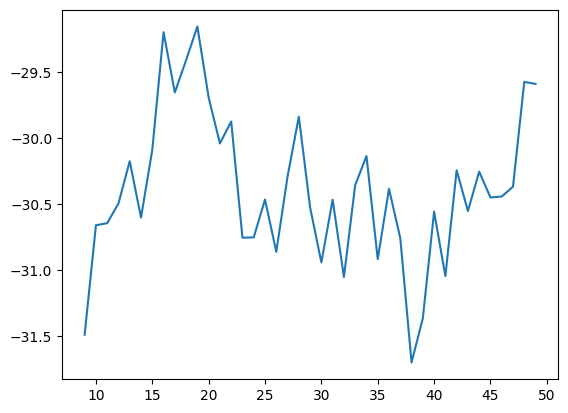

In [11]:
rewards_cumsum = pd.Series(rewards.cumsum(axis=1)[:, -1])

plt.plot(rewards_cumsum.rolling(10).mean())